## In this notebook, the following process will be performed.
## Notethat these steps have been carefully considerate based on EDA notebook (Please refer back to EDA.ipynb).

PART 1:
1. Data cleaning
    - dropping irrelevant feature(s)
2. Feature extraction
    - convert the value of the feature into more meaningful manner
    - combine multiple values into single one
3. Feature Scaling & Transformation
    - normalization and transformation on numerical feature(s)
4. Feature Encoding
    - one-hot encoding / ordinal encoding on categorical feature(s)

Finally, Model Training (PART 2)!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kagglehub
import os
from typing import Union
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)

In [2]:
def download_dataset(dataset: str,
                     extensions: tuple[int] = (".csv", ".json", ".xlsx"),
                     ) -> Union[str | Exception]:
    """
    Downloads a dataset using kagglehub and returns the path to the first file
    matching the specified extensions.

    Args:
        dataset (str): The identifier of the dataset to download.
        extensions (tuple[int], optional): A tuple of file extensions to look for.
            Defaults to (".csv", ".json", ".xlsx").

    Returns:
        Union[str, Exception]: The path to the first file with a matching extension,
        or an Exception if no matching file is found or an error occurs during download.
    """
    try:
        path = kagglehub.dataset_download(dataset)

        for file in os.listdir(path):
            if file.endswith(extensions):
                return os.path.join(path, file)

        return Exception("no matching file found")

    except Exception as e:
        return Exception(f"error occur while attempt to download dataset: {e}")
    
def read_dataset(file_path: str) -> Union[pd.DataFrame | str | None]:
    """
    Reads a dataset from a specified file path and returns it as a DataFrame.

    Parameters:
        file_path (str): The path to the dataset file. Supported formats are CSV, JSON, and XLSX.

    Returns:
        pd.DataFrame | str | None: Returns a DataFrame if the file is successfully read.
        Returns a string message if the file path is invalid or unsupported.
        Returns None if the file path is empty.
    """

    # Step 4: Load the dataset into a DataFrame
    if file_path:
        if file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        elif file_path.endswith(".json"):
            df = pd.read_json(file_path)
        elif file_path.endswith(".xlsx"):
            df = pd.read_excel(file_path)
        else:
            return "file_path cannot be empty!"

        return df

    else:
        return None

In [3]:
dataPath = "moro23/easyvisa-dataset"

filePath = download_dataset(dataset=dataPath)
df = read_dataset(file_path=filePath)
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
df.drop(labels=["case_id","requires_job_training"],inplace=True,axis=1)

PART 1.1: Data Cleaning

In [5]:
## Check features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')
print(features_with_na)

[]


In [6]:
## Check duplicate row
df.duplicated().sum()

0

In [7]:
from datetime import date

todays_date = date.today()
current_years = todays_date.year

In [8]:
df["company_age"] = current_years - df["yr_of_estab"]
df.drop(labels=["yr_of_estab"],inplace=True,axis=1)
df.head()

,continent,education_of_employee,has_job_experience,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,14513,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,2412,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,44444,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,98,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,1082,South,149907.3900,Year,Y,Certified,20


In [9]:
## Numeric faeture
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features), f"{num_features}")

## Categorical feature
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features),f"{cat_features}")

## Discrete feature
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features),f"{discrete_features}")

## Continuous feature
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features),f"{continuous_features}")

Num of Numerical Features : 3 ['no_of_employees', 'prevailing_wage', 'company_age']
Num of Categorical Features : 7 ['continent', 'education_of_employee', 'has_job_experience', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']
Num of Discrete Features : 0 []
Num of Continuous Features : 3 ['no_of_employees', 'prevailing_wage', 'company_age']


In [10]:
## Split data into X and y
X = df.drop(labels=["case_status"],axis=1)
y = df["case_status"]
print(X.head(), "\n\n")
print(y.head())

  continent education_of_employee has_job_experience  no_of_employees  \
0      Asia           High School                  N            14513   
1      Asia              Master's                  Y             2412   
2      Asia            Bachelor's                  N            44444   
3      Asia            Bachelor's                  N               98   
4    Africa              Master's                  Y             1082   

  region_of_employment  prevailing_wage unit_of_wage full_time_position  \
0                 West         592.2029         Hour                  Y   
1            Northeast       83425.6500         Year                  Y   
2                 West      122996.8600         Year                  Y   
3                 West       83434.0300         Year                  Y   
4                South      149907.3900         Year                  Y   

   company_age  
0           18  
1           23  
2           17  
3          128  
4           20   


0    

In [11]:
## Encode y
y = np.where(y=="Denied",1,0)


In [12]:
y

array([1, 0, 1, ..., 0, 0, 0])

## Feature Transformation


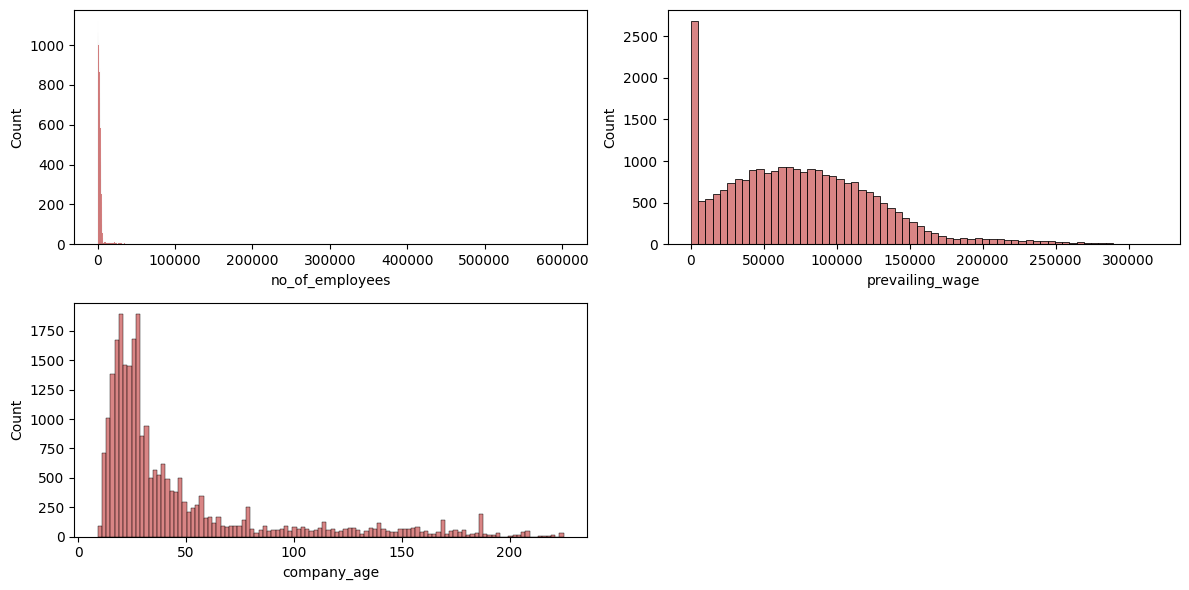

In [13]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [14]:
X[continuous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

In [ ]:
## Apply power transformer to make it modify its distribution towards normal distribution

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_copy = pt.fit_transform(X[continuous_features])
X_copy = pd.DataFrame(X_copy, columns=continuous_features)

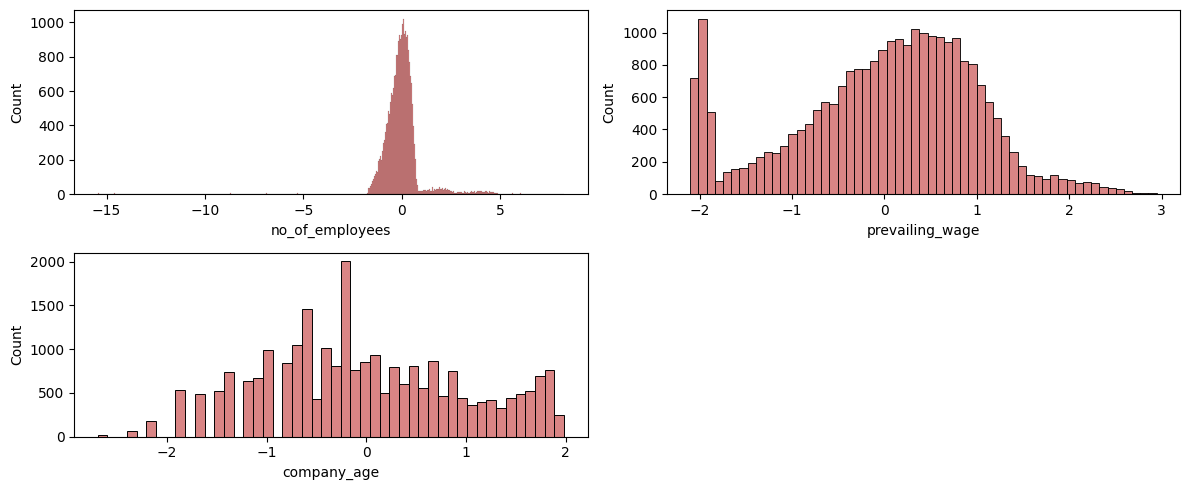

In [18]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [19]:
X_copy.skew(axis=0,skipna=True)

no_of_employees    0.399339
prevailing_wage   -0.338620
company_age        0.112260
dtype: float64

In [20]:
for feature in cat_features:
    print(f"{feature} : {df[feature].nunique()}")

continent : 6
education_of_employee : 4
has_job_experience : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


#### Feature Encoding & Scaling

In [21]:
transform_columns = num_features
## one-hot encoding
oh_columns = ["education_of_employee","has_job_experience","full_time_position"]
## ordinal-encoding
or_columns = ["continent", "unit_of_wage","region_of_employment"]

In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [23]:
X = preprocessor.fit_transform(X)

In [26]:
X

array([[ 0.        ,  0.        ,  1.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  0.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 1.        ,  0.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  0.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 1.        ,  0.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

#### Model Training : Classification

In [ ]:
from imblearn.combine import SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)